In [1]:

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb

from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix

### NOT TOUCHING VALIDATION SET FOR BETA MODEL


In [2]:
metadata = pd.read_csv("/kaggle/input/isic-kdag/subject_data_train.csv")

/tmp/ipykernel_32/63248436.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/kaggle/input/isic-kdag/subject_data.csv")


In [5]:
missing_counts = metadata.isna().sum()

print(missing_counts)

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

### DROP REDUNDANT COLUMNS (too much missing data)

In [6]:
metadata.drop(columns=['iddx_2','iddx_3','iddx_4','iddx_5','lesion_id','mel_mitotic_index','mel_thick_mm'], inplace=True)

missing_counts = metadata.isna().sum()

print(missing_counts)
print(len(metadata))

isic_id                             0
target                              0
patient_id                          0
age_approx                       2798
sex                             11517
anatom_site_general              5756
clin_size_long_diam_mm              0
image_type                          0
tbp_tile_type                       0
tbp_lv_A                            0
tbp_lv_Aext                         0
tbp_lv_B                            0
tbp_lv_Bext                         0
tbp_lv_C                            0
tbp_lv_Cext                         0
tbp_lv_H                            0
tbp_lv_Hext                         0
tbp_lv_L                            0
tbp_lv_Lext                         0
tbp_lv_areaMM2                      0
tbp_lv_area_perim_ratio             0
tbp_lv_color_std_mean               0
tbp_lv_deltaA                       0
tbp_lv_deltaB                       0
tbp_lv_deltaL                       0
tbp_lv_deltaLB                      0
tbp_lv_delta

### IMPUTE MISSING ROWS


In [7]:
if "age_approx" in metadata.columns:
    med_age = metadata["age_approx"].median()
    metadata["age_approx"] = metadata["age_approx"].fillna(med_age)

for col in ["sex", "anatom_site_general"]:
    metadata[col] = metadata[col].fillna("missing").astype(str)


missing_counts = metadata.isna().sum()

print(missing_counts)
print(len(metadata))

isic_id                         0
target                          0
patient_id                      0
age_approx                      0
sex                             0
anatom_site_general             0
clin_size_long_diam_mm          0
image_type                      0
tbp_tile_type                   0
tbp_lv_A                        0
tbp_lv_Aext                     0
tbp_lv_B                        0
tbp_lv_Bext                     0
tbp_lv_C                        0
tbp_lv_Cext                     0
tbp_lv_H                        0
tbp_lv_Hext                     0
tbp_lv_L                        0
tbp_lv_Lext                     0
tbp_lv_areaMM2                  0
tbp_lv_area_perim_ratio         0
tbp_lv_color_std_mean           0
tbp_lv_deltaA                   0
tbp_lv_deltaB                   0
tbp_lv_deltaL                   0
tbp_lv_deltaLB                  0
tbp_lv_deltaLBnorm              0
tbp_lv_eccentricity             0
tbp_lv_location                 0
tbp_lv_locatio

In [8]:
for col in metadata.columns:
    print(col, len(metadata[col].unique()))

isic_id 401059
target 2
patient_id 1042
age_approx 16
sex 3
anatom_site_general 6
clin_size_long_diam_mm 1758
image_type 1
tbp_tile_type 2
tbp_lv_A 386052
tbp_lv_Aext 385304
tbp_lv_B 389890
tbp_lv_Bext 387763
tbp_lv_C 390703
tbp_lv_Cext 388865
tbp_lv_H 389798
tbp_lv_Hext 390743
tbp_lv_L 395726
tbp_lv_Lext 396358
tbp_lv_areaMM2 8029
tbp_lv_area_perim_ratio 167648
tbp_lv_color_std_mean 371189
tbp_lv_deltaA 398257
tbp_lv_deltaB 398886
tbp_lv_deltaL 396505
tbp_lv_deltaLB 395511
tbp_lv_deltaLBnorm 396877
tbp_lv_eccentricity 396648
tbp_lv_location 21
tbp_lv_location_simple 8
tbp_lv_minorAxisMM 75669
tbp_lv_nevi_confidence 395242
tbp_lv_norm_border 391372
tbp_lv_norm_color 368742
tbp_lv_perimeterMM 9492
tbp_lv_radial_color_std_max 367566
tbp_lv_stdL 396459
tbp_lv_stdLExt 390080
tbp_lv_symm_2axis 74825
tbp_lv_symm_2axis_angle 36
tbp_lv_x 398446
tbp_lv_y 382410
tbp_lv_z 392817
attribution 7
copyright_license 3
iddx_full 52
iddx_1 3
tbp_lv_dnn_lesion_confidence 131480


## FEATURE ENGINEERING

In [9]:
def feature_engineering(df):
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity", 
        "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",
        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

metadata, new_num_cols, new_cat_cols = feature_engineering(metadata.copy())
    
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols

cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(metadata[cat_cols])
for c, cat_col in enumerate(cat_cols):
    metadata[cat_col] = X_cat[:, c]

In [10]:
pd.set_option('display.max_rows', None)
print(metadata.dtypes)

isic_id                            object
target                              int64
patient_id                         object
age_approx                        float64
sex                                 int64
anatom_site_general                object
clin_size_long_diam_mm            float64
image_type                         object
tbp_tile_type                       int64
tbp_lv_A                          float64
tbp_lv_Aext                       float64
tbp_lv_B                          float64
tbp_lv_Bext                       float64
tbp_lv_C                          float64
tbp_lv_Cext                       float64
tbp_lv_H                          float64
tbp_lv_Hext                       float64
tbp_lv_L                          float64
tbp_lv_Lext                       float64
tbp_lv_areaMM2                    float64
tbp_lv_area_perim_ratio           float64
tbp_lv_color_std_mean             float64
tbp_lv_deltaA                     float64
tbp_lv_deltaB                     

#### TRAIN TEST SPLIT GROUPED BY PATIENT-ID TO AVOID DATA LEAKAGE IN CROSS VALIDATION

In [11]:
X = np.arange(len(metadata))  # indices or features, not important for splitting
y = metadata['target']
groups = metadata['patient_id']

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X, y, groups):
    train_df = metadata.iloc[train_idx]
    val_df = metadata.iloc[val_idx]
    break

In [12]:
train_df = train_df.reset_index(drop=True)

## MODELLING 

LGBM performed best when compared adjacent to other GBDTs. Our final tabular model consists of a soft Voting ensemble which consists of 5 LGBM units, trained at different random_states

In [13]:
def comp_pauc(y_true, y_pred, min_tpr=0.80):
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = 1.0 - np.asarray(y_pred)
    max_fpr = abs(1 - min_tpr)
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (pauc_scaled - 0.5)
    return pauc

train_cols = [c for c in train_df.columns if c not in ["target", "patient_id"] and train_df[c].dtype != 'O']


# SMOTE on train data
sm = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = sm.fit_resample(train_df[train_cols], train_df["target"])

# PARAMS TUNED USING OPTUNA WITH PAUC OBJECTIVE
lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators": 500,
    'learning_rate': 0.01,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.75,
    'neg_bagging_fraction': 0.05,
    'feature_fraction': 0.8,
    'lambda_l1': 0.8,
    'lambda_l2': 0.8,
    "verbosity": -1,
}

models = []
for seed in [42, 52, 62, 72, 82]:
    params = lgb_params.copy()
    params['random_state'] = seed
    models.append((f"lgbm_{seed}", lgb.LGBMClassifier(**params)))

In [ ]:
# Voting ensemble
voter = VotingClassifier(estimators=models, voting='soft', n_jobs=-1)
voter.fit(X_res, y_res)

### METRICS


In [15]:
y_pred_prob = voter.predict_proba(val_df[train_cols])[:, 1]
y_pred_class = (y_pred_prob >= 0.5).astype(int)

print(classification_report(val_df["target"], y_pred_class))
print("pAUC:", comp_pauc(val_df["target"], y_pred_prob))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     71081
           1       0.01      0.81      0.02        83

    accuracy                           0.90     71164
   macro avg       0.50      0.85      0.48     71164
weighted avg       1.00      0.90      0.94     71164

pAUC: 0.1583572313479802


In [16]:
cm = confusion_matrix(val_df["target"], y_pred_class)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[63695  7386]
 [   16    67]]


In [17]:
importances = np.zeros(len(train_cols))
for name, model in voter.named_estimators_.items():
    importances += model.feature_importances_

importances /= len(voter.named_estimators_)

fi_df = pd.DataFrame({
    "feature": train_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(fi_df.head(20))

                         feature  importance
38  tbp_lv_dnn_lesion_confidence      1215.8
0                     age_approx      1002.2
2         clin_size_long_diam_mm       696.8
26        tbp_lv_nevi_confidence       690.2
10                      tbp_lv_H       639.2
43       lesion_color_difference       537.8
36                      tbp_lv_y       511.2
22           tbp_lv_eccentricity       494.8
61         3d_lesion_orientation       465.0
25            tbp_lv_minorAxisMM       438.2
45          3d_position_distance       412.2
3                  tbp_tile_type       398.0
13                   tbp_lv_Lext       389.6
1                            sex       384.6
41                  hue_contrast       383.2
18                 tbp_lv_deltaB       379.4
14                tbp_lv_areaMM2       345.8
34       tbp_lv_symm_2axis_angle       335.8
37                      tbp_lv_z       327.2
51          size_age_interaction       254.4


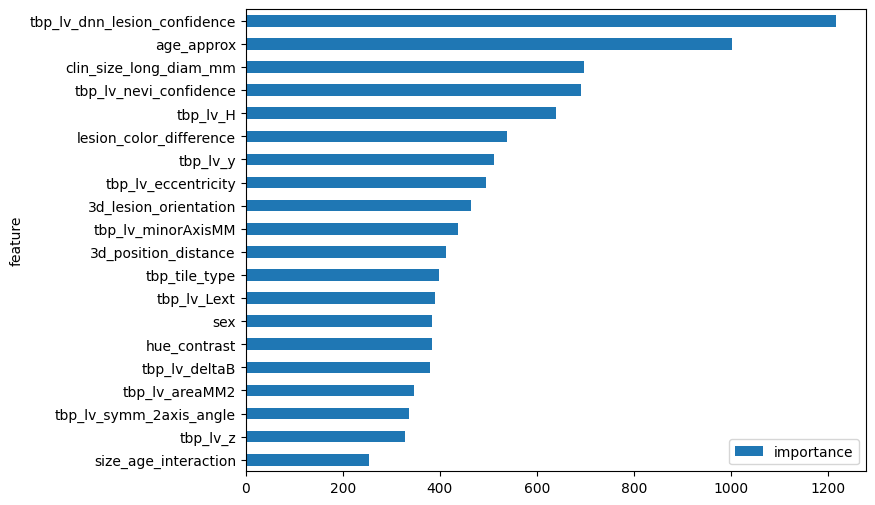

In [18]:

fi_df.head(20).plot(kind='barh', x='feature', y='importance', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.show()

In [19]:
preds_dict = {}
for name, model in voter.named_estimators_.items():
    preds_dict[name] = model.predict_proba(metadata[train_cols])[:, 1]

preds_df = pd.DataFrame(preds_dict)
preds_df["ensemble"] = voter.predict_proba(metadata[train_cols])[:, 1]
preds_df["target"] = metadata["target"].values
preds_df["isic_id"] = metadata["isic_id"].values

print(preds_df.head())

    lgbm_42   lgbm_52   lgbm_62   lgbm_72   lgbm_82  ensemble  target  \
0  0.015197  0.012859  0.018430  0.014540  0.013881  0.014981       0   
1  0.994896  0.994877  0.994858  0.994904  0.994728  0.994852       0   
2  0.009457  0.008784  0.008883  0.007815  0.008454  0.008679       0   
3  0.017314  0.013926  0.014249  0.014940  0.013991  0.014884       0   
4  0.203507  0.222469  0.274706  0.196490  0.217909  0.223016       0   

        isic_id  
0  ISIC_0015670  
1  ISIC_0015845  
2  ISIC_0015864  
3  ISIC_0015902  
4  ISIC_0024200  


In [27]:
preds_df.to_csv('tabular_preds.csv')